In [38]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from model import EnvNet
from train import train_model
from data_preprocess import make_frames,make_frames_folder
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Dense,Flatten,BatchNormalization,Dropout, Activation
from gammatone_init import GammatoneInit
from gammatone_init import generate_filters
from model_config import *
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import ast
import wandb


In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
frame_length = 16000
overlapping_fraction = 0.5
data = torch.load('./torch_dataset_16khz/all_audio_data.pt')
print(data.size())

torch.Size([54033, 16001])


In [41]:
def to_categorical(tensors, num_classes=10):
    return torch.eye(num_classes)[y.int()]
print(data.size())
tensor_size = (data.size())[0]
print(tensor_size)

torch.Size([54033, 16001])
54033


In [42]:
X_train = data[:,0:frame_length].clone()
test_portion = int(0.8*((data.size())[0]))
#print(test_portion)
X_train = data[:test_portion, 0:frame_length].clone()
#print(X_train.size())
Y_train = data[:test_portion,frame_length:].clone()

X_train = X_train.reshape(-1,16,1000)

#print(X_train.size())
#print(Y_train.size())
#print(Y_train)

In [52]:
Y_train = Y_train.type(torch.LongTensor)
Y_train_one_hot = F.one_hot(Y_train)
#print(Y_train_one_hot)
#print(Y_train)
audio_dataset = TensorDataset (X_train, Y_train)
audio_dataloader = DataLoader (audio_dataset, batch_size = 300, shuffle= True)

In [53]:
sample_rate = 16000
min_center_freq = 100
order = 2

In [54]:
class RMSLELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self, pred, actual):
        return self.mse(torch.log(pred.float() + 1), torch.log(actual.float() + 1))
 

In [55]:
loss_function = torch.nn.CrossEntropyLoss()
input = torch.randn(100, 10, requires_grad=True)
target = torch.empty(100, dtype=torch.long).random_(5)
print(input.size())
print(target.size())


torch.Size([100, 10])
torch.Size([100])


In [56]:
from featureblocks import FeatureBlock3
# The trinity of models
model = FeatureBlock3()
#model = FeatureBlockGT()
# This is the losss function
#loss_function = RMSLELoss()
loss_function = torch.nn.CrossEntropyLoss()
# This is what controls the gradient descent
#optimizer = torch.optim.Adadelta(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
iteration = 0
losses = []

#wandb.init(project='end2end1D')
#config = wandb.config

#wandb.watch(model)
#model.train()

for epoch in range(100):
    
    for index,(x,y) in enumerate(audio_dataloader):
        optimizer.zero_grad()
        #print(x.size())
        x = model(x.float())
        #print(x.size())
        #print(y.size())
        # Use argmax to get class with max probability value from softmax
        #x = x.argmax(dim=-1) 
        x = x.float()
        y = y.squeeze(1)
        
        loss = loss_function(x,y)
        loss.backward()
        optimizer.step()
        print("iteration:{} loss:{} ".format(iteration, loss.item()))
        losses.append(loss)
        iteration += 1
        
        #wandb.log({"loss": loss, "epoch": epoch})
        
        
#using wandb to visualize


iteration:0 loss:2.303006410598755 
iteration:1 loss:2.3017044067382812 
iteration:2 loss:2.300416946411133 
iteration:3 loss:2.302067995071411 
iteration:4 loss:2.300279378890991 
iteration:5 loss:2.3015553951263428 
iteration:6 loss:2.3010153770446777 
iteration:7 loss:2.299685001373291 
iteration:8 loss:2.3008289337158203 
iteration:9 loss:2.2995641231536865 
iteration:10 loss:2.3007009029388428 
iteration:11 loss:2.2997376918792725 
iteration:12 loss:2.3012640476226807 
iteration:13 loss:2.3005690574645996 
iteration:14 loss:2.2997312545776367 
iteration:15 loss:2.2995307445526123 
iteration:16 loss:2.2989962100982666 
iteration:17 loss:2.2988736629486084 
iteration:18 loss:2.3017008304595947 
iteration:19 loss:2.2995986938476562 
iteration:20 loss:2.298128366470337 
iteration:21 loss:2.2997355461120605 
iteration:22 loss:2.299292802810669 
iteration:23 loss:2.2979111671447754 
iteration:24 loss:2.297729730606079 
iteration:25 loss:2.2999820709228516 
iteration:26 loss:2.2981507778

In [49]:
shape = [16,16,64]
filters = generate_filters(shape[2],shape[0],sample_rate,min_center_freq,order)
filters = filters.reshape(filters.shape[1],1,filters.shape[0])


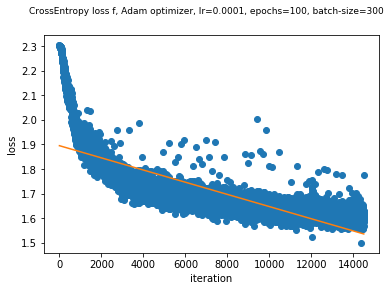

In [58]:
import matplotlib.pyplot as plt

y = np.array(losses, dtype=float)
x = np.arange(len(losses))

plt.xlabel("iteration")
plt.ylabel("loss")
plt.suptitle("CrossEntropy loss f, Adam optimizer, lr=0.0001, epochs=100, batch-size=300", fontsize=9)

m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'o')
plt.plot(x, m*x+b)